In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. SETTINGS & HARDWARE CONFIG ---
# Optimized for 2x T4 GPUs (32GB VRAM total)
BATCH_SIZE = 16 
EPOCHS = 50
LEARNING_RATE = 2e-4
IMG_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DYNAMIC PATH HANDLING ---
# This ensures the code works regardless of nested folder naming
BASE = '/kaggle/input/rs-haze-dataset/rshaze'
TRAIN_HAZY = os.path.join(BASE, 'train/hazy')
TRAIN_GT = os.path.join(BASE, 'train/GT')
TEST_HAZY = os.path.join(BASE, 'test/hazy')
TEST_GT = os.path.join(BASE, 'test/GT')

# Verify and debug paths
paths = {"Train Hazy": TRAIN_HAZY, "Train GT": TRAIN_GT, "Test Hazy": TEST_HAZY, "Test GT": TEST_GT}
for name, p in paths.items():
    if not os.path.exists(p):
        print(f"❌ {name} folder MISSING at: {p}")
    else:
        print(f"✅ {name} folder found: {len(os.listdir(p))} images.")

# --- 3. DATASET & AUGMENTATION ---
class DehazeDataset(Dataset):
    def __init__(self, hazy_path, gt_path, transform=None):
        self.hazy_path = hazy_path
        self.gt_path = gt_path
        self.hazy_imgs = sorted([f for f in os.listdir(hazy_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.gt_imgs = sorted([f for f in os.listdir(gt_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.hazy_imgs)

    def __getitem__(self, idx):
        hazy_img = Image.open(os.path.join(self.hazy_path, self.hazy_imgs[idx])).convert('RGB')
        gt_img = Image.open(os.path.join(self.gt_path, self.gt_imgs[idx])).convert('RGB')

        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            hazy_img = self.transform(hazy_img)
            torch.manual_seed(seed)
            gt_img = self.transform(gt_img)
        return hazy_img, gt_img

# Augmentations improve "excellence" by helping the model generalize
train_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
])

test_transform = T.Compose([T.Resize(IMG_SIZE), T.ToTensor()])

train_ds = DehazeDataset(TRAIN_HAZY, TRAIN_GT, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

test_ds = DehazeDataset(TEST_HAZY, TEST_GT, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# --- 4. EXCELLENT MODEL: ATTENTION-RESUNET ---

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return x * self.sigmoid(avg_out + max_out)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch)
        )
        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.ca = ChannelAttention(out_ch)

    def forward(self, x):
        return self.ca(F.relu(self.conv(x) + self.shortcut(x)))

class ExcellentResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = ResBlock(3, 64)
        self.e2 = ResBlock(64, 128)
        self.e3 = ResBlock(128, 256)
        self.e4 = ResBlock(256, 512)
        
        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.d3 = ResBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.d2 = ResBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.d1 = ResBlock(128, 64)
        
        self.final = nn.Sequential(nn.Conv2d(64, 3, 3, padding=1), nn.Sigmoid())

    def forward(self, x):
        s1 = self.e1(x)
        s2 = self.e2(F.max_pool2d(s1, 2))
        s3 = self.e3(F.max_pool2d(s2, 2))
        s4 = self.e4(F.max_pool2d(s3, 2))
        
        x = self.d3(torch.cat([self.up3(s4), s3], dim=1))
        x = self.d2(torch.cat([self.up2(x), s2], dim=1))
        x = self.d1(torch.cat([self.up1(x), s1], dim=1))
        return self.final(x)

# --- 5. HYBRID LOSS & METRICS ---

class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:16].eval().to(DEVICE)
        for param in vgg.parameters(): param.requires_grad = False
        self.vgg = vgg
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        l1_loss = self.l1(pred, target)
        vgg_loss = self.mse(self.vgg(pred), self.vgg(target))
        return l1_loss + 0.05 * vgg_loss

def get_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# Multi-GPU Init
model = ExcellentResUNet()
if torch.cuda.device_count() > 1:
    print(f"🚀 Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(DEVICE)

criterion = HybridLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# --- 6. TRAINING LOOP ---
best_psnr = 0
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for hazy, gt in loop:
        hazy, gt = hazy.to(DEVICE), gt.to(DEVICE)
        optimizer.zero_grad()
        out = model(hazy)
        loss = criterion(out, gt)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    val_psnr = 0
    with torch.no_grad():
        for hazy, gt in test_loader:
            hazy, gt = hazy.to(DEVICE), gt.to(DEVICE)
            out = model(hazy)
            val_psnr += get_psnr(out, gt).item()
    
    avg_psnr = val_psnr / len(test_loader)
    print(f"📊 Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | PSNR: {avg_psnr:.2f}dB")
    
    scheduler.step(avg_psnr)
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(model.state_dict(), 'best_dehaze_model.pth')
        print(f"⭐ New Best Model Saved (PSNR: {best_psnr:.2f}dB)")

# --- 7. FINAL VISUALIZATION ---
model.eval()
with torch.no_grad():
    hazy, gt = next(iter(test_loader))
    out = model(hazy.to(DEVICE))
    
    imgs = [hazy[0].cpu().permute(1, 2, 0), out[0].cpu().permute(1, 2, 0), gt[0].cpu().permute(1, 2, 0)]
    titles = ["Hazy Input", "ResUNet Output", "Ground Truth"]
    
    plt.figure(figsize=(15, 8))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(imgs[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

✅ Train Hazy folder found: 51300 images.
✅ Train GT folder found: 51300 images.
✅ Test Hazy folder found: 2700 images.
✅ Test GT folder found: 2700 images.
🚀 Using 2 GPUs!
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 214MB/s]  
Epoch 1/50: 100%|██████████| 3207/3207 [43:03<00:00,  1.24it/s, loss=0.034] 


📊 Epoch 1 | Loss: 0.0529 | PSNR: 31.53dB
⭐ New Best Model Saved (PSNR: 31.53dB)


Epoch 2/50: 100%|██████████| 3207/3207 [43:12<00:00,  1.24it/s, loss=0.0501]


📊 Epoch 2 | Loss: 0.0418 | PSNR: 32.41dB
⭐ New Best Model Saved (PSNR: 32.41dB)


Epoch 3/50: 100%|██████████| 3207/3207 [43:11<00:00,  1.24it/s, loss=0.0589]


📊 Epoch 3 | Loss: 0.0383 | PSNR: 32.17dB


Epoch 4/50: 100%|██████████| 3207/3207 [43:12<00:00,  1.24it/s, loss=0.0414]


📊 Epoch 4 | Loss: 0.0361 | PSNR: 32.76dB
⭐ New Best Model Saved (PSNR: 32.76dB)


Epoch 5/50: 100%|██████████| 3207/3207 [43:13<00:00,  1.24it/s, loss=0.0326]


📊 Epoch 5 | Loss: 0.0346 | PSNR: 32.69dB


Epoch 6/50: 100%|██████████| 3207/3207 [43:12<00:00,  1.24it/s, loss=0.0538]


📊 Epoch 6 | Loss: 0.0335 | PSNR: 32.89dB
⭐ New Best Model Saved (PSNR: 32.89dB)


Epoch 7/50: 100%|██████████| 3207/3207 [43:12<00:00,  1.24it/s, loss=0.0417]


📊 Epoch 7 | Loss: 0.0324 | PSNR: 33.53dB
⭐ New Best Model Saved (PSNR: 33.53dB)


Epoch 8/50: 100%|██████████| 3207/3207 [43:12<00:00,  1.24it/s, loss=0.0736]


📊 Epoch 8 | Loss: 0.0317 | PSNR: 33.91dB
⭐ New Best Model Saved (PSNR: 33.91dB)


Epoch 9/50: 100%|██████████| 3207/3207 [43:13<00:00,  1.24it/s, loss=0.0276]


📊 Epoch 9 | Loss: 0.0310 | PSNR: 33.95dB
⭐ New Best Model Saved (PSNR: 33.95dB)


Epoch 10/50:  39%|███▉      | 1265/3207 [17:04<26:13,  1.23it/s, loss=0.0286]


KeyboardInterrupt: 

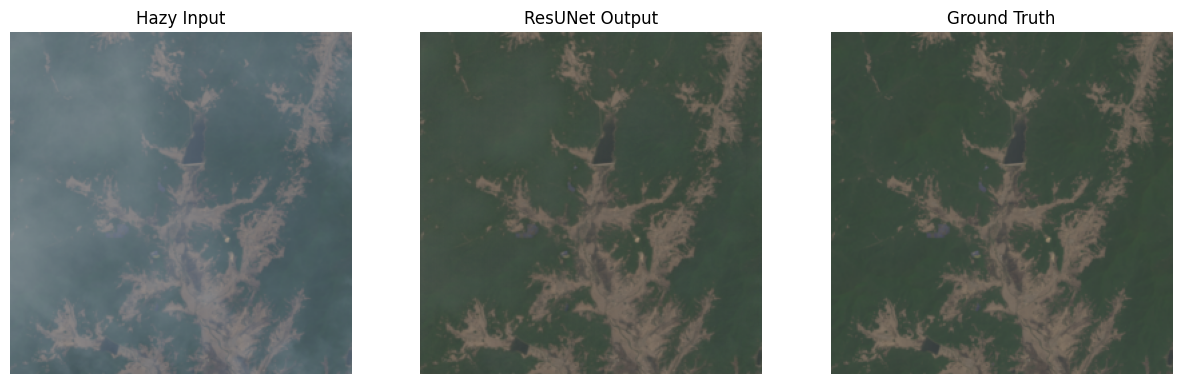

In [5]:
model.eval()
with torch.no_grad():
    hazy, gt = next(iter(test_loader))
    out = model(hazy.to(DEVICE))
    
    imgs = [hazy[0].cpu().permute(1, 2, 0), out[0].cpu().permute(1, 2, 0), gt[0].cpu().permute(1, 2, 0)]
    titles = ["Hazy Input", "ResUNet Output", "Ground Truth"]
    
    plt.figure(figsize=(15, 8))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(imgs[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [6]:
import os
if os.path.exists('/kaggle/working/best_dehaze_model.pth'):
    print("✅ Success! Your model is saved on the Kaggle disk.")
    print(f"File Size: {os.path.getsize('/kaggle/working/best_dehaze_model.pth') / 1e6:.2f} MB")
else:
    print("❌ Model file not found in /kaggle/working/")

✅ Success! Your model is saved on the Kaggle disk.
File Size: 32.49 MB


In [7]:
from IPython.display import FileLink
FileLink(r'best_dehaze_model.pth')

/kaggle/working/best_dehaze_model.pth